In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul


from bnpmodeling_runjingdev import log_phi_lib
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Load data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
# data_file='/accounts/grad/runjing_liu/BNP/fastStructure/hgdp_data/' + \
#             'huang2011_plink_files/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [5]:
print(n_obs)
print(n_loci)

20
50


# file paths

In [6]:
fits_dir = '../fits/tmp/' 

filenames = 'simulated_fit'
alpha0 = 6.0

init_fit_file = fits_dir + filenames + '_alpha' + str(alpha0) + '.npz'
lr_file = fits_dir + filenames + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# fits_dir = '../fits/fits_20201122/'
# filename = fits_dir + 'huang2011_fit_alpha6.0.npz'

# Load initial fit for its metadata

In [7]:
_, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)

# Helper functions

In [23]:
def get_free_params_from_lr_and_refit(perturbation): 
    
    #################
    # load initial fit
    #################
    print('loading initial fit from: ', init_fit_file)
    vb_opt_dict, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)
    
    alpha0 = prior_params_dict['dp_prior_alpha']
    vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)
    
    #################
    # load linear response derivatives
    #################
    print('loading derivatives from: ', lr_file)
    lr_data = np.load(lr_file)
    assert lr_data['alpha0'] == alpha0
    assert np.all(lr_data['vb_opt'] == vb_opt)
    assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8
    
    print('saved derivative time: {:.3f}secs'.format(lr_data['lr_time_alpha']))
    
    ##################
    # load refit results
    ##################
    match_crit = filenames + '_' + perturbation + '\d+.npz'
    refit_files = [f for f in os.listdir(fits_dir) if re.match(match_crit, f)]
    
    assert len(refit_files) > 0, 'no refit files found'
    
    optim_time_vec = []
    epsilon_vec = []
    vb_refit_list = []

    for i in range(len(refit_files)): 

        print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(fits_dir + refit_files[i])
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    ###############
    # get linear response predictions 
    
    def predict_opt_par_from_hyper_par(epsilon): 
        return vb_opt + lr_data['dinput_dfun_' + perturbation] * epsilon
    
    lr_list = []
    for epsilon in epsilon_vec: 
        # get linear response
        lr_list.append(predict_opt_par_from_hyper_par(epsilon))
    
    return vb_refit_list, np.array(lr_list), optim_time_vec, epsilon_vec

# Define number of clusters

In [24]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                       key = key,
                                                       n_samples = 1000)

# Plot results

In [33]:
def plot_lr_results(perturbation): 
    # get free parameters
    vb_refit_list, lr_list, optim_time_vec, epsilon_vec = \
        get_free_params_from_lr_and_refit(perturbation)
    
    # get expected number of clusters
    lr_e_num_clusters_vec = onp.zeros(len(epsilon_vec))
    refit_e_num_clusters_vec = onp.zeros(len(epsilon_vec))

    for i in range(len(epsilon_vec)): 
        print(i)
        refit_e_num_clusters_vec[i] = g(vb_refit_list[i], vb_params_paragami)
        lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)
    
    # plot
    plt.plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

    plt.plot(epsilon_vec, lr_e_num_clusters_vec, 
               'o-', color = '#1b9e77', 
               label = 'linear approx.')

    plt.legend()

loading initial fit from:  ../fits/tmp/simulated_fit_alpha6.0.npz
loading derivatives from:  ../fits/tmp/simulated_fit_alpha6.0_lrderivatives.npz
saved derivative time: 0.432secs
loading fit from:  simulated_fit_worst-case8.npz
loading fit from:  simulated_fit_worst-case1.npz
loading fit from:  simulated_fit_worst-case6.npz
loading fit from:  simulated_fit_worst-case7.npz
loading fit from:  simulated_fit_worst-case0.npz
loading fit from:  simulated_fit_worst-case9.npz
loading fit from:  simulated_fit_worst-case3.npz
loading fit from:  simulated_fit_worst-case4.npz
loading fit from:  simulated_fit_worst-case10.npz
loading fit from:  simulated_fit_worst-case5.npz
loading fit from:  simulated_fit_worst-case2.npz
0
1
2
3
4
5
6
7
8
9
10


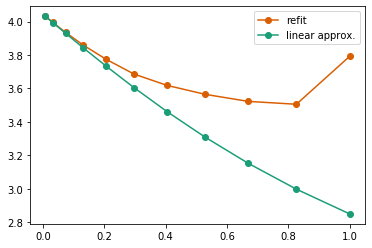

In [34]:
plot_lr_results('worst-case')

loading initial fit from:  ../fits/tmp/simulated_fit_alpha6.0.npz
loading derivatives from:  ../fits/tmp/simulated_fit_alpha6.0_lrderivatives.npz
saved derivative time: 0.432secs
loading fit from:  simulated_fit_sigmoidal3.npz
loading fit from:  simulated_fit_sigmoidal4.npz
loading fit from:  simulated_fit_sigmoidal5.npz
loading fit from:  simulated_fit_sigmoidal2.npz
loading fit from:  simulated_fit_sigmoidal10.npz
loading fit from:  simulated_fit_sigmoidal8.npz
loading fit from:  simulated_fit_sigmoidal1.npz
loading fit from:  simulated_fit_sigmoidal6.npz
loading fit from:  simulated_fit_sigmoidal7.npz
loading fit from:  simulated_fit_sigmoidal0.npz
loading fit from:  simulated_fit_sigmoidal9.npz
0
1
2
3
4
5
6
7
8
9
10


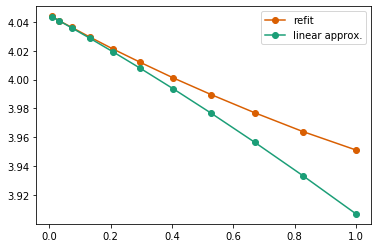

In [35]:
plot_lr_results('sigmoidal')

loading initial fit from:  ../fits/tmp/simulated_fit_alpha6.0.npz
loading derivatives from:  ../fits/tmp/simulated_fit_alpha6.0_lrderivatives.npz
saved derivative time: 0.432secs
loading fit from:  simulated_fit_sigmoidal_neg4.npz
loading fit from:  simulated_fit_sigmoidal_neg3.npz
loading fit from:  simulated_fit_sigmoidal_neg10.npz
loading fit from:  simulated_fit_sigmoidal_neg2.npz
loading fit from:  simulated_fit_sigmoidal_neg5.npz
loading fit from:  simulated_fit_sigmoidal_neg6.npz
loading fit from:  simulated_fit_sigmoidal_neg1.npz
loading fit from:  simulated_fit_sigmoidal_neg8.npz
loading fit from:  simulated_fit_sigmoidal_neg9.npz
loading fit from:  simulated_fit_sigmoidal_neg0.npz
loading fit from:  simulated_fit_sigmoidal_neg7.npz
0
1
2
3
4
5
6
7
8
9
10


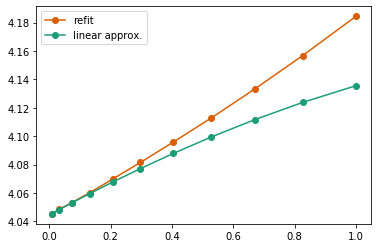

In [36]:
plot_lr_results('sigmoidal_neg')

loading initial fit from:  ../fits/tmp/simulated_fit_alpha6.0.npz
loading derivatives from:  ../fits/tmp/simulated_fit_alpha6.0_lrderivatives.npz
saved derivative time: 0.432secs
loading fit from:  simulated_fit_alpha_pert_pos8.npz
loading fit from:  simulated_fit_alpha_pert_pos6.npz
loading fit from:  simulated_fit_alpha_pert_pos1.npz
loading fit from:  simulated_fit_alpha_pert_pos0.npz
loading fit from:  simulated_fit_alpha_pert_pos7.npz
loading fit from:  simulated_fit_alpha_pert_pos9.npz
loading fit from:  simulated_fit_alpha_pert_pos4.npz
loading fit from:  simulated_fit_alpha_pert_pos10.npz
loading fit from:  simulated_fit_alpha_pert_pos3.npz
loading fit from:  simulated_fit_alpha_pert_pos2.npz
loading fit from:  simulated_fit_alpha_pert_pos5.npz
0
1
2
3
4
5
6
7
8
9
10


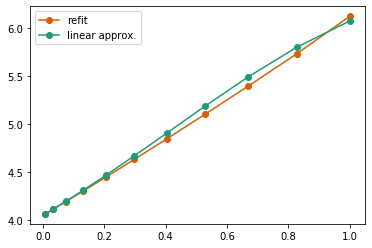

In [37]:
plot_lr_results('alpha_pert_pos')

loading initial fit from:  ../fits/tmp/simulated_fit_alpha6.0.npz
loading derivatives from:  ../fits/tmp/simulated_fit_alpha6.0_lrderivatives.npz
saved derivative time: 0.432secs
loading fit from:  simulated_fit_alpha_pert_neg5.npz
loading fit from:  simulated_fit_alpha_pert_neg2.npz
loading fit from:  simulated_fit_alpha_pert_neg3.npz
loading fit from:  simulated_fit_alpha_pert_neg4.npz
loading fit from:  simulated_fit_alpha_pert_neg9.npz
loading fit from:  simulated_fit_alpha_pert_neg7.npz
loading fit from:  simulated_fit_alpha_pert_neg0.npz
loading fit from:  simulated_fit_alpha_pert_neg1.npz
loading fit from:  simulated_fit_alpha_pert_neg6.npz
loading fit from:  simulated_fit_alpha_pert_neg8.npz
loading fit from:  simulated_fit_alpha_pert_neg10.npz
0
1
2
3
4
5
6
7
8
9
10


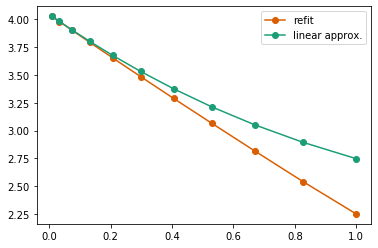

In [38]:
plot_lr_results('alpha_pert_neg')